# API de Idealista

La web de Idealista proporcion una API para la descarga gratuita de sus datos.
En primer lugar debermos registrarnos a través del enlace:  https://developers.idealista.com/access-request
   
Una vez realizado el registro, Idealista envía un email con las claves de acceso (Apikey, Secret) y las instrucciones de manejo de la API en forma de documentos adjuntos.

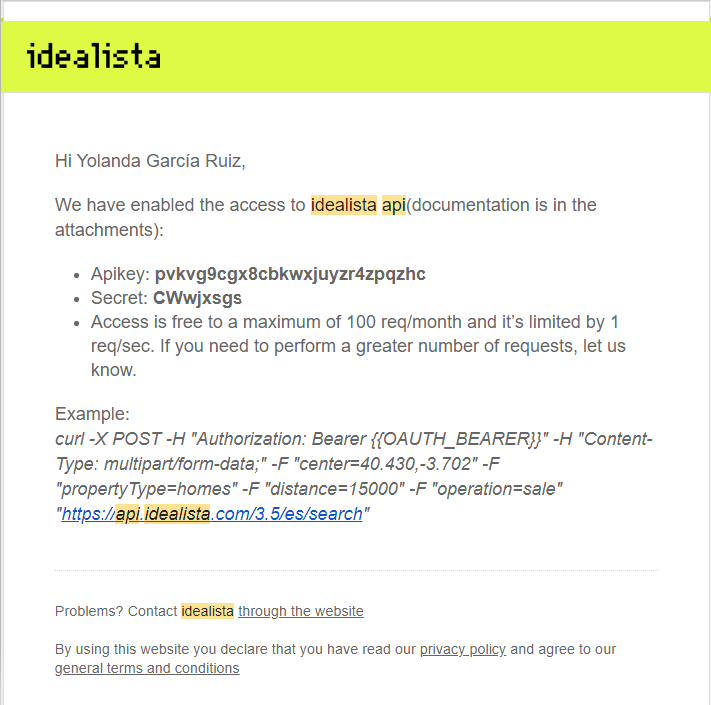

Revisando la documentación encontraréis información acerca de las restricciones de uso de la API:

* No más de 100 peticiones por usuario y mes 
* No más de 1 petición por segundo
* Cada petición devuelve un máximo de 50 viviendas
* Las peticiones han de realizarse usando coordenadas geoespaciales


In [23]:
Apikey = 'km6c9v3bezyoop5iij4cjhyrnu04mhrv'
Secret = 'hcnxemZzpmQM'

Además de las claves de acceso, Idealista usa un segundo nivel de seguridad llamado OAuth. Se trata de un protocolo llamado OAuth seguro que  permite a las aplicaciones autenticar a los usuarios e interactuar con Idealista en su nombre. 

En este caso, las peticiones no se realizan mediante una url, sino que se realizarán mediante un par (autorización, contenido). 

A continuación mostramos las funciones Python que automatizan el proceso de construir dicho par (creo que en este enlace encontré la forma de hacerlo, ya que no encontré mucha documentación: https://stackoverflow.com/questions/40023931/how-to-get-real-estate-data-with-idealista-api):



In [1]:
import pandas as pd
import json

import requests 
import base64
from time import gmtime, strftime

# Generar la autorizacón de usuario a partir de las claves de acceso
#--------------------------------------------------------------------
def get_oauth_token(API_KEY, SECRET):
    url = "https://api.idealista.com/oauth/token"    
    apikey= API_KEY #sent by idealista
    secret= SECRET  #sent by idealista
    
    message = API_KEY + ":" + SECRET
    auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii")
    headers_dic = {"Authorization" : auth, 
                   "Content-Type" : "application/x-www-form-urlencoded;charset=UTF-8"}
    params_dic = {"grant_type" : "client_credentials",
                  "scope" : "read"}   
    content = requests.post(url,headers = headers_dic, params=params_dic)
    bearer_token = json.loads(content.text)['access_token']
    return bearer_token


def search_api(token, url):  
    h = {'Content-Type': 'Content-Type: multipart/form-data;', 
         'Authorization' : 'Bearer ' + token}
    content = requests.post(url, headers = h)
    try:
        result = json.loads(content.text)
    except:
        result = []
    return content.status_code, result

Usando las dos funciones anteriores podemos consultar datos de Idealista. Se pueden aplicar filtros a la consulta. Algunos de los filtros permitidos son los siguientes. Pero hay más (consultar la documentación de la API). 

In [2]:
# filtros permitidos:
country = 'es' #values: es, it, pt
locale = 'es' #values: es, it, pt, en, ca
language = 'es' #
max_items = '5'    # 50 as maximun allowed
operation = 'sale'    # values: sale, rent
property_type = 'homes'   # values: homes, offices, premises, garages, bedrooms
flat = 'True'
order = 'priceDown' 
center = '40.3271,-3.8628'   # geographic coordinates ( WGS84) (latitude, longitude)
distance = '6000'            # distance to center, in metres (ratio)
maxprice = '130000.00'
sort = 'desc'
bankOffer = 'false'

Montamos la consulta con los filtros anteriores:

In [3]:
url = ('https://api.idealista.com/3.5/'+country+'/search?operation='+operation+
           #"&locale="+locale+
           '&maxItems='+max_items+
           '&order='+order+
           '&center='+center+
           '&maxprice='+maxprice+
           '&flat='+flat+ 
           '&distance='+distance+
           '&propertyType='+property_type+
           '&sort='+sort+ 
           '&numPage=%s'+
           '&language='+language) # %(i)  


print(url)


https://api.idealista.com/3.5/es/search?operation=sale&maxItems=5&order=priceDown&center=40.3271,-3.8628&maxprice=130000.00&flat=True&distance=6000&propertyType=homes&sort=desc&numPage=%s&language=es


In [8]:
Apikey = 'km6c9v3bezyoop5iij4cjhyrnu04mhrv'
Secret = 'hcnxemZzpmQM'


x = get_oauth_token(Apikey,Secret)
code, datos = search_api(x, url)

if code == 200:
    df = pd.DataFrame.from_dict(datos['elementList'])
    df['fecha_descarga'] = strftime("%d %m %Y %H:%M:%S", gmtime())   # fecha de la descarga de idealista
    print("Se ha creado la tabla con nombre: df")
    df.to_excel('data.xlsx', index = False)
else:
    print(code)

Se ha creado la tabla con nombre: df


In [9]:
df

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,superTopHighlight,externalReference,highlight,fecha_descarga
0,100980873,https://img3.idealista.com/blur/WEB_LISTING/0/...,13,1,159900.0,flat,sale,82.0,True,3,...,"{'subtitle': 'Zona Centro Joven, Alcorcón', 't...",False,False,False,False,False,False,NaN,NaN,25 04 2023 16:05:01
1,99570027,https://img3.idealista.com/blur/WEB_LISTING/0/...,10,2,117000.0,flat,sale,65.0,True,2,...,"{'subtitle': 'Centro, Móstoles', 'title': 'Pis...",False,False,False,False,False,False,RNM-1234,NaN,25 04 2023 16:05:01
2,101061474,https://img3.idealista.com/blur/WEB_LISTING/0/...,10,4,101000.0,flat,sale,57.0,True,2,...,"{'subtitle': 'Centro, Móstoles', 'title': 'Pis...",False,False,False,False,False,False,NaN,{'groupDescription': 'Destacado'},25 04 2023 16:05:01
3,100956882,https://img3.idealista.com/blur/WEB_LISTING/0/...,7,5,101000.0,penthouse,sale,57.0,True,2,...,"{'subtitle': 'Centro, Móstoles', 'title': 'Áti...",False,False,False,False,False,False,13248-2025,NaN,25 04 2023 16:05:01
4,100622811,https://img3.idealista.com/blur/WEB_LISTING/0/...,21,1,229000.0,flat,sale,131.0,True,4,...,"{'subtitle': 'Norte - Universidad, Móstoles', ...",True,False,False,False,False,False,NaN,{'groupDescription': 'Destacado'},25 04 2023 16:05:01


Información devuelta por la API:

In [10]:
datos.keys()

dict_keys(['elementList', 'total', 'totalPages', 'actualPage', 'itemsPerPage', 'numPaginations', 'summary', 'alertName', 'totalAppliedFilters', 'upperRangePosition', 'paginable', 'lowerRangePosition'])

In [11]:
datos['totalPages']

190

In [12]:
datos['actualPage']

1

In [13]:
datos['itemsPerPage']

5

In [14]:
tabla['numPaginations']

0

In [15]:
tabla['paginable']

True